# Assignment 8 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.3.1 installed. This means, you should be able to use it without any changes to your environment.
If you activate the `gt` environment, as shown at the end of [Assignment 6](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) you can use pytorch version 1.4 and tensorflow 2.1 (not required in this assignment).

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/checkpoints
```

As an aside, since `~/.cache` can contain several folders (e.g. `pip` package downloads) whose size can exceed your quota, it may be a good idea to create a `dotcache` folder in your scratch space and create a symbolic link to it from `~/.cache`.

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [70]:
# to check GPU memory, uncomment and run the following line
!{'nvidia-smi'}

Mon Mar  9 02:42:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 960     Off  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P2    24W / 160W |   1357MiB /  2000MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**Here is an example of the training data:**

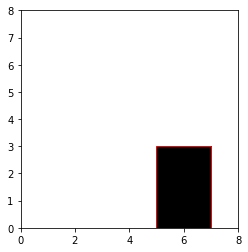

In [25]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [26]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [27]:
model = nn.Sequential(
    nn.Linear(64, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 4),
)

In [28]:
# optimizer = torch.optim.Adadelta(model.parameters())
lr=1e-6
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_fn = torch.nn.MSELoss(size_average=False)


In [29]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

In [ ]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(10000):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


In [ ]:
plt.plot(loss_record)

In [ ]:
# change the model from training to evaluation mode to improve testing performance
phase = 'test'
model.eval()

In [ ]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

In [ ]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

In [ ]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

In [73]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

from torch.utils.data import DataLoader,TensorDataset

train_x_tensor = Variable(torch.Tensor(train_X))
train_y_tensor = Variable(torch.Tensor(train_y))
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)

test_x_tensor = Variable(torch.Tensor(test_X))
test_y_tensor = Variable(torch.Tensor(test_y))
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=20)
test_loader = DataLoader(dataset=test_dataset, batch_size=20)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = nn.Sequential(
    nn.Linear(64, 200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 4),
).to(device)

optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

losses = []
test_losses = []
train_step = make_train_step(model, loss_fn, optimizer)
n_epochs =30

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        running_loss += loss.data * inputs.size(0)
        epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
        loss_record.append(epoch_loss)
#     with torch.no_grad():
#         for x_test, y_test in test_loader:
#             x_test = x_test.to(device)
#             y_test = y_test.to(device)
            
#             model.eval()

#             yhat = model(x_test)
#             test_loss = loss_fn(y_test, yhat)
#             test_losses.append(test_loss.item())
    print(epoch)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
OrderedDict([('0.weight', tensor([[-3.2038e-01,  6.3150e-02,  2.1390e-02,  ...,  1.3365e-01,
          2.4417e-01,  1.0273e-01],
        [-3.7704e-02,  6.4079e-02,  2.3752e-02,  ...,  1.0084e-01,
          2.5200e-01,  1.0954e-01],
        [-1.0332e-01,  1.2688e-01,  3.5053e-02,  ...,  1.7363e-01,
          2.2426e-01,  1.5978e-01],
        ...,
        [ 1.6001e-04,  5.4185e-02, -1.9924e-01,  ...,  2.2823e-01,
          2.9779e-02,  8.3246e-02],
        [ 1.2318e-01,  9.2447e-03, -1.1233e-01,  ...,  6.9084e-01,
          5.9298e-01,  5.1285e-01],
        [-1.2578e-01, -1.0428e-01, -1.1072e-01,  ...,  1.2291e-01,
          2.9538e-01,  2.5154e-01]], device='cuda:0')), ('0.bias', tensor([-0.0313,  0.1314, -0.0832,  0.0322, -0.2405,  0.0569, -0.0117, -0.1434,
        -0.0130, -0.0051,  0.0830, -0.0978, -0.1240, -0.0369,  0.1469, -0.1028,
        -0.1381, -0.2023,  0.0733,  0.0988, -0.0504,  0.0347, -0.3931, -

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

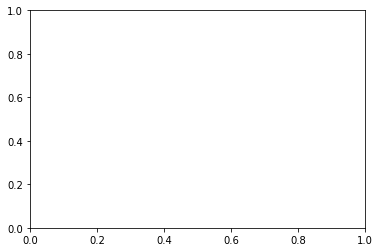

In [77]:
plt.plot(test_loss)

In [ ]:
# Predict bounding boxes on the test images.
pred_y = model(test_x_sensor)
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup, fill out the answer to Task 2.2 below.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network without the modificiation that you applied in 2.3 above) so that you can detect one out of 1000 classes. Please fill out your the answer to Task 2.4 below.

# Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/tfl_tut.py)

In [7]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

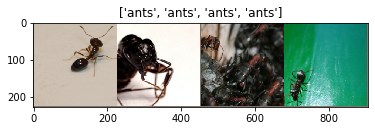

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
model_conv = torchvision.models.resnet18(pretrained=True)

### Answer for Task 2.2

In [9]:
# TODO paste and maybe modify relevant code to perform your own training

In [ ]:
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [ ]:
# TODO

### Answer for Task 2.4

In [11]:
# TODO

Please include the picture and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb) containing answers to Task 1 and for Task 2 including some portions of the transfer learning tutorial notebook in the sections above corresponding to tasks 2.1 - 2.4.